In [ ]:
!git clone https://github.com/muxspace/facial_expressions.git

In [1]:
%cd /Users/helenfeng/Programming/BSE/

/Users/helenfeng/Programming/BSE


In [2]:
%matplotlib inline
from pylab import *
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
from collections import Counter
import time
import PIL
import pickle
import cv2

In [3]:
def saveData(src, pklname, csv_path, width=350, height=None):
    # assuming you have the current file structure:
    # ./
    #   data/
    #   images/
    height = height if height is not None else width

    data = dict() # our data structure
    data['desc'] = 'resized ({0}x{1}) face images in rgb'.format(width, height)
    data['label'] = []
    data['filename'] = []
    data['image'] = []

    pklname = f"{pklname}_{width}x{height}px.pkl" # filename for pickle file: 'emotions_350x350px.pkl', fun fact: this is standard practice for saving data in ML!
    
    if os.path.exists(pklname):
        os.remove(pklname)
        
    csv_data = pd.read_csv(csv_path) # create dataframe to match labels and images        
    
    for i in range(len(csv_data)):
        csv_data.iloc[i]['emotion'] = csv_data.iloc[i]['emotion'].lower()

    # get images from dir
    for subdir in os.listdir(src): # src should be '.'
        if subdir == 'images': # grabs images/
            curr_path = os.path.join(src, subdir) # combines ./ and images/ --> ./images/ 
            for file in tqdm(os.listdir(curr_path)): # iterates through files in ./images/
    #         if file[-3:] in {'jpg', 'png'}: 
                try:
                    im = imread(os.path.join(curr_path, file))
                    im = resize(im, (width, height))
                    c = np.expand_dims(im, axis=-1)
        
                    if c.shape[2] != 1:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
                    index = csv_data.index[csv_data['image']==file][0] # get index of the file we are looking at in the csv file
                    data['label'].append(csv_data.iloc[index]['emotion']) # uses iloc (operated by index) to get element (emotion in str form)
                    
                    data['filename'].append(file) # image name
                    data['image'].append(im) # image data
                    
                except Exception:
                    continue       
            break
            

    f = open(pklname, "wb")
    pickle.dump(data, open(pklname,"wb")) # pickle.dump creates a pickle file with our data structure and dumps it into the pickle file with pklname
    print('done')
    f.close()
    return

In [5]:
pklname = 'emotions'
width = 350
include = 'data/legend.csv'

saveData(os.curdir, pklname, csv_path=include, width=width)

100%|██████████| 13718/13718 [02:17<00:00, 99.53it/s] 


done


In [4]:
from collections import Counter

with open('emotions_350x350px.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()

In [5]:
print('number of samples: ', len(data['image']))
print('keys: ', list(data.keys()))
print('description: ', data['desc'])
print('image shape: ', data['image'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  12758
keys:  ['desc', 'label', 'filename', 'image']
description:  resized (350x350) face images in rgb
image shape:  (350, 350)
labels: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'surprise']


Counter({'neutral': 6713,
         'happiness': 5306,
         'surprise': 355,
         'sadness': 124,
         'anger': 227,
         'disgust': 12,
         'fear': 12,
         'contempt': 9})

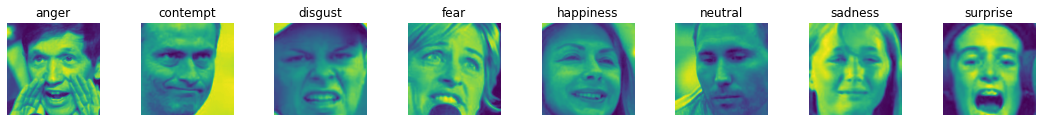

In [6]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['image'][idx])
    ax.axis('off')
    ax.set_title(label)

# Start organizing data into train/test sets

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['image'], 
    data['label'], 
    test_size=0.2, 
    shuffle=True,
    random_state=21
)

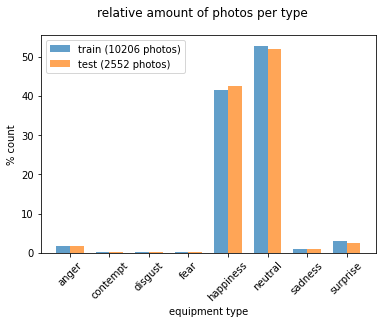

In [8]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

# processing

hog stands for histogram oriented gradients and is used for feature extraction

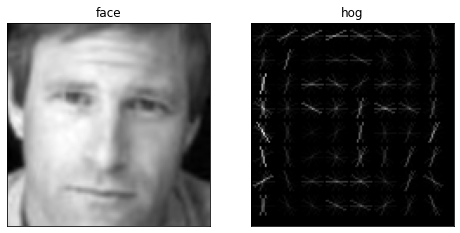

In [9]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
face = imread('images/Aaron_Eckhart_0001.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
face = rescale(face, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    face, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(face, cmap='gray')
ax[0].set_title('face')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [10]:
print('number of pixels: ', face.shape[0] * face.shape[1])
print('number of hog features: ', dog_hog.shape[0])


number of pixels:  13689
number of hog features:  1764


Define the RGB --> Gray Transformer, HOG transformer, which will be used in the pipeline for later optimization


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])    

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
                    
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
# grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
print('instances')

# call fit_transform on each transform converting X_train step by step
X_train_hog = hogify.fit_transform(X_train)
print('hogified')
X_train_prepared = scalify.fit_transform(X_train_hog)
print('scalified')
 
print(X_train_prepared.shape)

instances
hogified
scalified
(10206, 20736)


Create the [SGD Classifier (stochastic gradient descent)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.fit)

- fits a linear SVM by default
- helps us complete the HOG and SVM process for image detection

In [13]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [14]:
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)


In [15]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True False  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  80.56426332288402


In [18]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


In [19]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


In [20]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[   4,    0,    0,    0,    8,   32,    0,    1],
       [   0,    0,    0,    0,    1,    1,    0,    0],
       [   0,    0,    0,    0,    0,    5,    0,    0],
       [   0,    0,    0,    0,    0,    1,    1,    0],
       [   2,    0,    0,    0,  821,  260,    0,    1],
       [   4,    0,    0,    0,   83, 1215,    6,   19],
       [   0,    0,    0,    0,    3,   22,    1,    0],
       [   0,    0,    0,    0,    1,   45,    0,   15]])


 ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


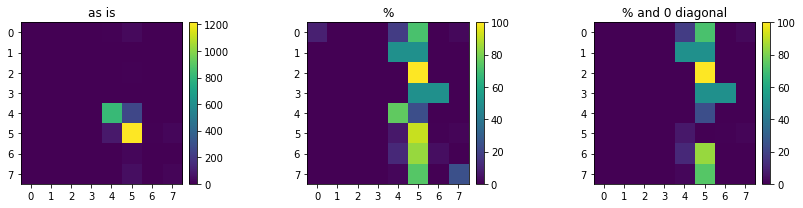

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

# Optimization

use a pipeline to edit params more and put entire process in one place (transformers and sgd classifier)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])


Percentage correct:  80.56426332288402


Grid search
- an optimization algorithm 
- allows us to select the best parameters from a list of parameter options that you provide
   - automates the 'trial-and-error' method

In [27]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [ ]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
#                            n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated 

<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated 

<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated 

<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-11-053643a432f0>:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated 

In [ ]:
# save the model
pickle.dump(grid_res, 'hog_sgd_model.pkl');